## Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import geopandas
import plotly.express as px
import numpy
import seaborn as sns
import os

In [9]:
crime_table = pd.read_csv("../Data/crime/crime_statistics.csv")
filtered = crime_table[crime_table["Unit of measure"] == "Per hundred thousand inhabitants"]
filtered["TIME_PERIOD"] = filtered["TIME_PERIOD"].astype(int)
years = sorted(filtered["TIME_PERIOD"].unique())
states=crime_table["Geopolitical entity (reporting)"].unique()
grouped = (
    filtered.groupby(["Geopolitical entity (reporting)", "TIME_PERIOD"])["OBS_VALUE"]
    .sum()
    .reset_index()
    .rename(columns={
        "TIME_PERIOD": "Year",
        "Geopolitical entity (reporting)": "Country",
        "OBS_VALUE": "Total_Crime"
    })
)
#print(crime_table["Geopolitical entity (reporting)"].unique())
eu_data = grouped[grouped["Country"].isin(states)]
eu_mean = (
    eu_data.groupby("Year")["Total_Crime"]
    .mean()
    .reindex(years, fill_value=0)
    .reset_index()
    .rename(columns={"Total_Crime": "EU_Mean"})
)

y_min = grouped["Total_Crime"].min()
y_max = grouped["Total_Crime"].max()
padding = (y_max - y_min) * 0.05
y_min -= padding
y_max += padding

# for state in grouped["Country"].unique():
#     country_data = (
#         grouped[grouped["Country"] == state]
#         .set_index("Year")
#         .reindex(years, fill_value=0)
#         .reset_index()
#     )

#     plt.figure()
#     plt.plot(country_data["Year"], country_data["Total_Crime"], label=state, marker='o')
#     plt.plot(eu_mean["Year"], eu_mean["EU_Mean"], label="EU Mean", linestyle='--', color='red')

#     plt.title(f"Total Crime per Year in {state}")
#     plt.xlabel("Year")
#     plt.ylabel("Total Crime (per 100,000 inhabitants)")
#     plt.ylim(y_min, y_max)
#     plt.xticks(years, rotation=45)
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     output_dir = os.path.join("..", "Images", "Countries", state)
#     file_name = f"crime_rate_{state}.png"
#     file_path = os.path.join(output_dir, file_name)
    # if os.path.isdir(output_dir):
    #     plt.savefig(file_path)
    # else:
    #     print(f"Directory not found for {state}: {output_dir}")

    # plt.show()



/tmp/ipykernel_226449/2775197425.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Using Jacob's draw_choropleth function and creating choropleth graphs

In [10]:
def draw_choropleth(data, column,range=None,save_name=None,title="",color_scheme=None):
  if color_scheme is None:
    cmap = "Plasma"
  else:
    cmap = color_scheme
    
  if range is not None:
    fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      range_color=range,
      color_continuous_scale=cmap
    )
  else:
      fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      color_continuous_scale=cmap
      )

  fig.update_geos(lonaxis_range= [-20, 40],lataxis_range= [30, 72])
  fig.update_layout(height=500, margin={"r":0,"t":50,"l":0,"b":30},
                    title={
        'text': title,
        'y':0.96,  # Position from top (0 to 1)
        'x':0.5,    # Center the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=18) })
  fig.show()

country_iso_dict = {
    'Albania': 'ALB',
    'Austria': 'AUT',
    'Bosnia and Herzegovina': 'BIH',
    'Belgium': 'BEL',
    'Bulgaria': 'BGR',
    'Switzerland': 'CHE',
    'Cyprus': 'CYP',
    'Czechia': 'CZE',
    'Germany': 'DEU',
    'Denmark': 'DNK',
    'Estonia': 'EST',
    'Greece': 'GRC',
    'Spain': 'ESP',
    'Finland': 'FIN',
    'France': 'FRA',
    'Croatia': 'HRV',
    'Hungary': 'HUN',
    'Ireland': 'IRL',
    'Iceland': 'ISL',
    'Italy': 'ITA',
    'Liechtenstein': 'LIE',
    'Lithuania': 'LTU',
    'Luxembourg': 'LUX',
    'Latvia': 'LVA',
    'Montenegro': 'MNE',
    'North Macedonia': 'MKD',
    'Malta': 'MLT',
    'Netherlands': 'NLD',
    'Norway': 'NOR',
    'Poland': 'POL',
    'Portugal': 'PRT',
    'Romania': 'ROU',
    'Serbia': 'SRB',
    'Sweden': 'SWE',
    'Slovenia': 'SVN',
    'Slovakia': 'SVK',
    'Türkiye': 'TUR'
}



# for year in range(2014,2024):
#   map_data = grouped[grouped["Year"] == year].copy()
#   map_data['iso_alpha'] = map_data['Country'].map(country_iso_dict)
#   map_data.set_index("iso_alpha", inplace=True)
#   draw_choropleth(
#       data=map_data,
#       column="Total_Crime",
#       title=f"Total Crime per 100,000 Inhabitants in {year}",
#       color_scheme=["white","red","darkred"]
#   )


#### Getting ratios of people of type over the years
- Result is rounded to 2 decimal places


Documentation:
- get_ratio_dataframe expects one argument: *citizenship_type*. if left **None**, it will calculate all foreigners.
- citizenship_type can be in
    - **EU28_FOR**: EU28 countries (2013-2020) except reporting country
    - **NEU28_FOR**: Non-EU28 countries (2013-2020) nor reporting country
    - **NAT**: Reporting country
    - **STLS**: Stateless
    - **TOTAL**: Total
    - **UNK**: Unknown

In [24]:
year_offset = 4
def get_citizenship_ratio(table,country,citizenship_type):
    try:
        foreign_ratios = []
        country_main = table.query("Country =='"+country+"' and sex=='T' and citizen == 'TOTAL'")
        iso3 = country_main.iloc[0,1]

        if citizenship_type is not None:
            country_foreign = table.query("Country =='"+country+"' and sex=='T' and citizen == '"+citizenship_type+"'")
        
            for i in range(10):
                foreign_ratios.append((country_foreign.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i]*100))

        #Calculate all foreign residents
        else:
            country_natural = table.query("Country =='"+country+"' and sex=='T' and citizen == 'NAT'")
            for i in range(10):
                foreign_ratios.append((100-((country_natural.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i])*100)).round(2))
        
        years = [str(x+2015) for x in range(10)]

        series_data = [iso3] + foreign_ratios
        index_labels = ['ISO3'] + years
        
        return pd.Series(series_data, index=index_labels, name=country)
        
    except:
        print("Error processing country: ",country)
        return None
    
def get_ratio_dataframe(table,citizenship_type=None):
    results = []

    for country in table["Country"].unique():
        result = get_citizenship_ratio(table,country,citizenship_type)
        if result is not None:
            results.append(result.to_dict())

    return pd.DataFrame.from_records(results).set_index("ISO3")


#### Drawing heatmap

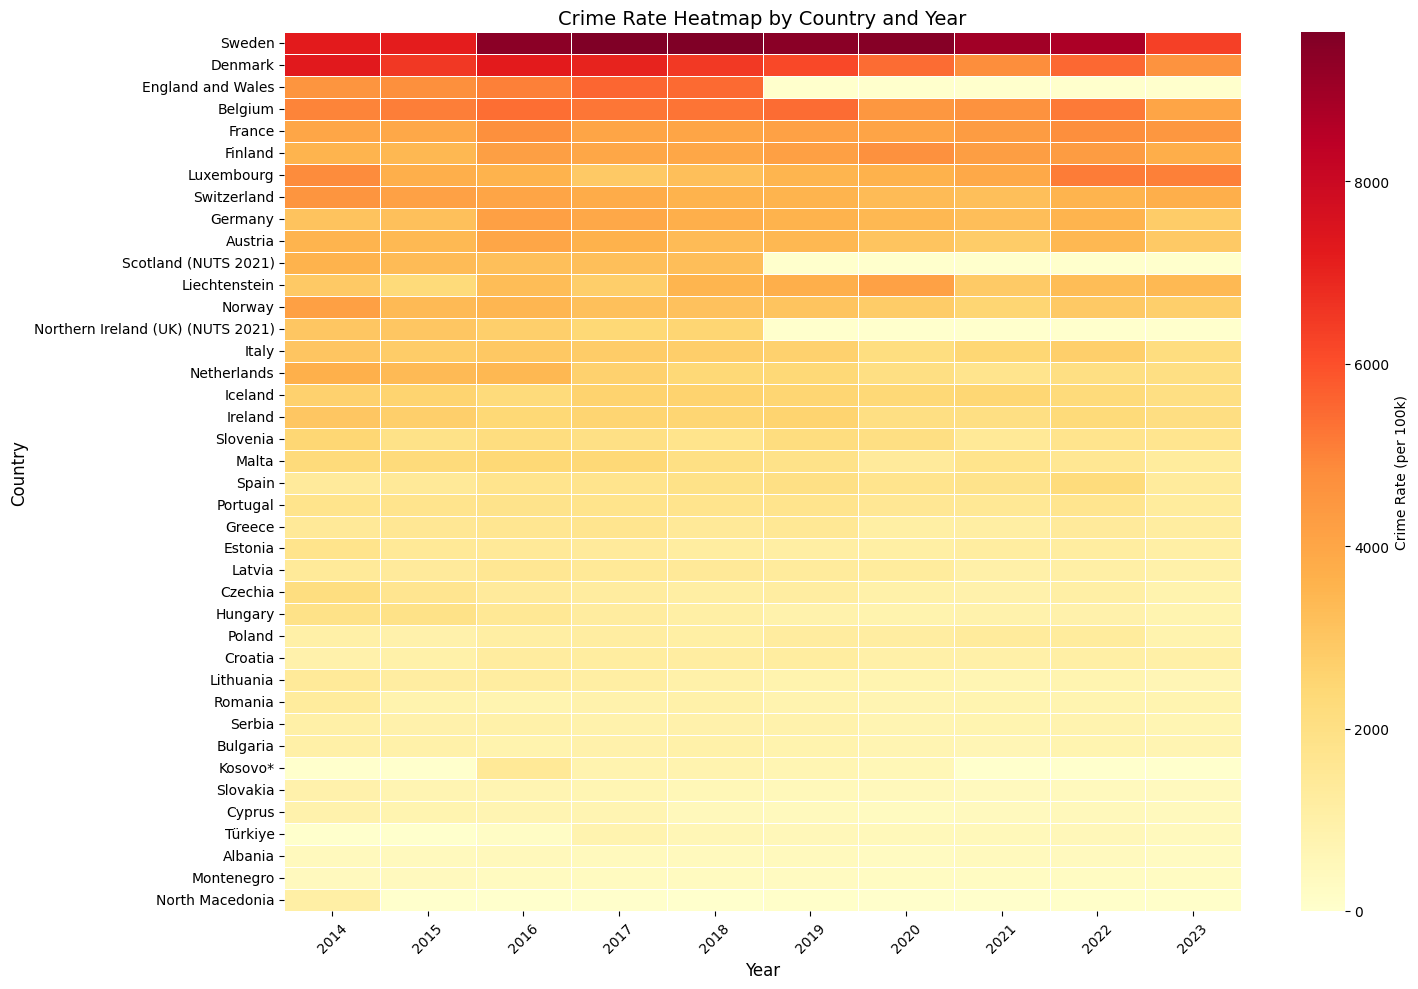

Error processing country:  Bulgaria
Error processing country:  Albania
Error processing country:  Armenia
Error processing country:  Georgia
Error processing country:  Moldova, Republic of
Error processing country:  Montenegro
Error processing country:  North Macedonia
Error processing country:  Serbia
Error processing country:  Ukraine


KeyError: "'light:b' is not a known colormap name"

<Figure size 1500x1000 with 0 Axes>

In [37]:


country_order = grouped.groupby("Country")["Total_Crime"].mean().sort_values(ascending=False).index
heatmap_data = grouped.pivot_table(
    index="Country",
    columns="Year",
    values="Total_Crime",
    fill_value=0
)
# display(heatmap_data.head())

heatmap_data = heatmap_data.loc[country_order]

def draw_heatmap(table, cmap, label):
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        table,
        annot=False,
        cmap=cmap,
        linewidths=0.5,
        cbar_kws={"label": label}
    )

    plt.title("Crime Rate Heatmap by Country and Year", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Country", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

draw_heatmap(heatmap_data,"YlOrRd","Crime Rate (per 100k)")

# non-eu population
# Done by Jakub


# calculate percentage
table_raw = pd.read_csv("../Data/Annual_population_eurostat(mandatory).csv")
# table_population = pd.read_csv("../Data/Annual_population_eurostat(mandatory).csv").query("sex =='T' and citizen == 'NEU28_FOR'").drop(columns=["ISO3","citizen","sex"]).set_index("Country")
table_population = get_ratio_dataframe(table_raw,"NEU28_FOR")

# display(table_population.head())

# heatmap2_data = table_population.loc[country_order]

draw_heatmap(table_population,"light:b","Population of non-eu residents")




